In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import librosa
import librosa.display
import shutil
import tensorflow as tf

from scipy.io import wavfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import ResNet101

### Convert audio's spectrogram to images

In [2]:
# path = 'data/audio'
# spectrogram_path = 'data/spectrogram'
# directories = os.listdir('data/audio')

In [3]:
# if not os.path.exists(spectrogram_path):
#     os.makedirs(spectrogram_path)
        
# for directory in directories:
#     dir_path = path + '/' + directory
#     files = os.listdir(dir_path)
    
#     for file in files:
#         audio_file = dir_path + '/' + file
#         new_file_path = (spectrogram_path + '/' + file).replace('.wav','.png')
#         samples, sample_rate = librosa.load(audio_file)
        
#         fig = plt.figure(figsize=[0.72,0.72])
#         ax = fig.add_subplot(111)
#         ax.axes.get_xaxis().set_visible(False)
#         ax.axes.get_yaxis().set_visible(False)
#         ax.set_frame_on(False)
        
#         S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
#         librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
#         plt.savefig(new_file_path, dpi=400, bbox_inches='tight',pad_inches=0)
#         plt.close('all')

### Data visualization

In [4]:
df = pd.read_csv('data/data.csv')
df.columns.values

array(['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold',
       'classID', 'class'], dtype=object)

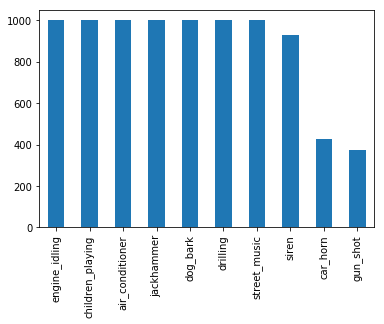

In [5]:
df['class'].value_counts().plot.bar()

In [6]:
df.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [7]:
df = df[['slice_file_name', 'class']]
df.head(5)

,slice_file_name,class
0,100032-3-0-0.wav,dog_bark
1,100263-2-0-117.wav,children_playing
2,100263-2-0-121.wav,children_playing
3,100263-2-0-126.wav,children_playing
4,100263-2-0-137.wav,children_playing


In [8]:
df['slice_file_name'] = df['slice_file_name'].str.replace('wav', 'png')

In [9]:
image_data = ImageDataGenerator(rotation_range=30,
                                rescale=1./255,
                                shear_range=0.15,
                                zoom_range=0.15,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                validation_split=0.25)

In [10]:
batch_size = 16
image_size = (150, 150, 3)

train = image_data.flow_from_dataframe(df,
                                       'data/spectrogram',
                                       x_col='slice_file_name',
                                       y_col='class',
                                       target_size=image_size[:2],
                                       batch_size=batch_size,
                                       class_mode='categorical',
                                       subset='training')
test = image_data.flow_from_dataframe(df,
                                      'data/spectrogram',
                                      x_col='slice_file_name',
                                      y_col='class',
                                      target_size=image_size[:2],
                                      batch_size=batch_size,
                                      class_mode='categorical',
                                      subset='validation')

Found 6549 validated image filenames belonging to 10 classes.
Found 2183 validated image filenames belonging to 10 classes.


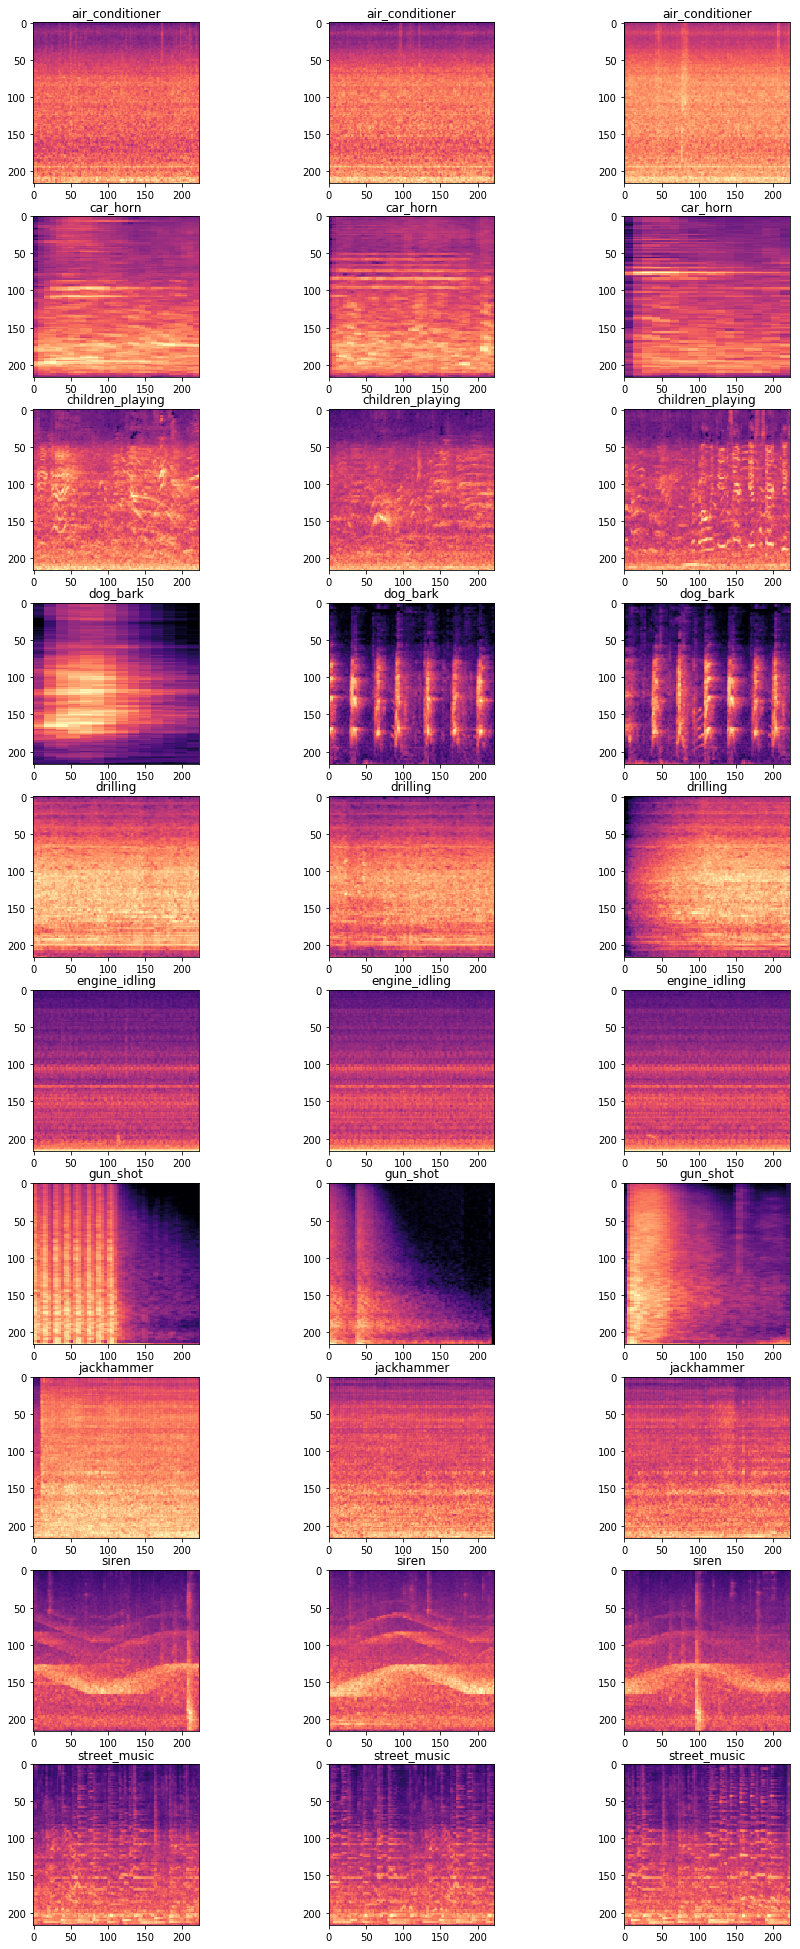

In [11]:
images = df.groupby('class').head(3).sort_values('class')
classes = images['class'].tolist()
file_names = images['slice_file_name'].tolist()

i = 0
fig, ax = plt.subplots(10, 3, figsize=(15, 35))

for j in range(len(file_names)):
    if j % 3 == 0 and j >= 3:
        i += 1
    data = plt.imread('data/spectrogram/' + file_names[j])
    ax[i][j%3].imshow(data)
    ax[i][j%3].set_title(classes[j])

### Create model

In [12]:
base_model = ResNet101(input_shape=image_size,
                       include_top=False,
                       weights='imagenet')

171450368/171446536 [==============================] - 82s 0us/step


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [15]:
model = Sequential([
    base_model,
    GlobalMaxPooling2D(),
    Dense(10)
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 5, 5, 2048)        42658176  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 42,678,666
Trainable params: 20,490
Non-trainable params: 42,658,176
_________________________________________________________________


### Fit model

In [17]:
results = model.fit_generator(train,
                              epochs=10,
                              validation_data=test,
                              validation_steps=test.samples//batch_size,
                              steps_per_epoch=train.samples//batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 409 steps, validate for 136 steps
Epoch 1/10
409/409 [==============================] - 169s 413ms/step - loss: 1.5593 - accuracy: 0.8987 - val_loss: 1.5419 - val_accuracy: 0.9000
Epoch 2/10
 55/409 [===>..........................] - ETA: 1:08 - loss: 1.5425 - accuracy: 0.9000

KeyboardInterrupt: 

In [ ]:
model.save('model.h5')

### Plot history

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].plot(results.history['accuracy'], label='Train accuracy')
ax[0].plot(results.history['val_accuracy'], label='Validation accuracy')
ax[0].legend(['Train accuracy', 'Validation accuracy'])

ax[1].plot(results.history['loss'], label='Train loss')
ax[1].plot(results.history['val_loss'], label='Validation loss')
ax[1].legend(['Train loss', 'Validation loss'])

plt.show()